In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision

from utils import *
from mnist_train import *

%load_ext autoreload
%autoreload 2

# Get MNIST

In [17]:
config = {
    "torch_random_seed": 1, 
    "batch_size": {"train_size": 64, "test_size": 1000},
    
    "num_epochs":  5, 
    
    "SGD_params": {"learning_rate": 0.01, "momentum": 0.9},
    "num_nets": 100, # would like to make it like other one, where we can define region to initialize
    "ess_threshold": 0.90, # resample if kish less than this
    
    "softmax_beta": -40, # negtive to prioritize low weights
    
    "weight_type": "loss_gradient_weights"#"input_output_forbenius",
    
}

## Try to do the example panos was talking about (x_i' - x_i)(x_j' - x_j) etc. 

# Training Loop 

In [ ]:
train(config)

[52 61 87  2 70 95 10 22 62 91  1 12 50 77 48 80 53 73 59 11 59 89 79  6
 77 34  6 71 89 40 53 51 44 48 23 16 82 54 31  6 71 50 18  8 43  2 32  5
 86 33 34 74 84 46 24 40  2 27  6 94 40 14 93 22 70 48 72 45 41 16 39 60
 43 78 82 68 91 51 27 82 56 63  2 96 67 83 52 94 31 13 94 87 65 22 36  6
 41 32 96 35]


In [ ]:
img1 = images[2]
img2 = images[4]
img3 = images[11]

label1 = float(labels[0].detach().numpy())
label2 = float(labels[1].detach().numpy())
label3 = float(labels[2].detach().numpy())

# v1, v2 = get_orthogonal_basis(img1, img2, img3)

v1 = vh[0] #_random_vector(img1.shape[1] * img1.shape[2], 1)[0]
v2 = vh[1] #_random_vector(img1.shape[1] * img1.shape[2], 1)[0]


# Get max/min alpha (v1) and beta (v2) 
alpha_bound = 500#15*abs(v1.dot(get_vec(img2) - get_vec(img1)))
beta_bound = 500 #15*abs(v2.dot(get_vec(img3) - get_vec(img1)))

X, Y, results, v1, v2 = classification_regions_2d(v1, v2, img1, -alpha_bound, alpha_bound, -beta_bound, beta_bound, 1000, nets[0])


In [ ]:
img1_vec = get_vec(img1)
img2_vec = get_vec(img2)
img3_vec = get_vec(img3)

a1 = 0
b1 = 0

a2 = v1.dot(img2_vec - img1_vec)
b2 = v2.dot(img2_vec - img1_vec)

a3 = v1.dot(img3_vec - img1_vec)
b3 = v2.dot(img3_vec - img1_vec)



In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[
            go.Heatmap(x = X, y=Y,
                    z=results,),

            go.Scatter(x=[a1], y=[b1], mode='markers', marker=dict(
                                                    color='LightSkyBlue',
                                                    size=20,
                                                    line=dict(
                                                        color='MediumPurple',
                                                        width=2
                                                    )
                                                )),
                        go.Scatter(x=[a2], y=[b2], mode='markers', marker=dict(
            color='LightSkyBlue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        )),
                        go.Scatter(x=[a3], y=[b3], mode='markers', marker=dict(
            color='LightSkyBlue',
            size=20,
            line=dict(
                color='MediumPurple',
                width=2
            )
        ))

                     
                     ])


fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


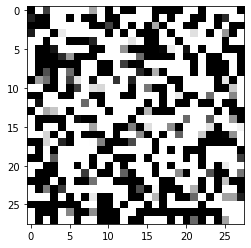

In [219]:
v1_img = v1.reshape(img1.shape[1:])
v2_img = v2.reshape(img2.shape[1:])

tmp = img1 + v1_img * 170 + -70 * v2_img

imshow(torchvision.utils.make_grid(tmp))


# Some analysis

In [ ]:
# Would like a grouped set by label. 

# For each label, calculate all directions with one reference (can get all others from this set. )

In [256]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=1, shuffle=False)

full_data = list(train_loader)

idx = {i: [] for i in range(10)}
for i, data in enumerate(full_data, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    label = labels.reshape(len(labels)).long()
    idx[int(label[0])].append(i)

In [257]:
label = 0

data = np.array([full_data[i][0].detach().numpy() for i in idx[label]])
data = data.reshape(data.shape[0], data.shape[3] * data.shape[4])

In [259]:
a = data - data[0]
b = a.dot(a.T)
print(np.argmin(np.diag(b[1:])))

640


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


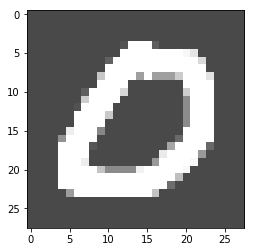

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


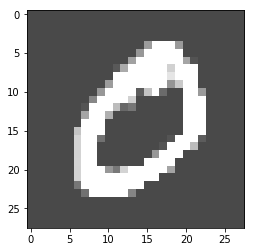

In [260]:
imshow(torchvision.utils.make_grid(torch.Tensor(data[640].reshape(1, 1, 28, 28))))
imshow(torchvision.utils.make_grid(torch.Tensor(data[0].reshape(1, 1, 28, 28))))

In [222]:
label = 9

data = np.array([full_data[i][0].detach().numpy() for i in idx[label]])
data = data.reshape(data.shape[0], data.shape[3] * data.shape[4])

In [221]:
zero_origin = data[0]
zero_far = data[4077]

In [223]:
nine_origin = data[0]

In [215]:
np.linalg.norm(f - data[0])**2 

1132.2532868853305

In [225]:
zz = zero_origin - zero_far
zn = zero_origin - nine_origin

zz.dot(zn) * (1./(np.linalg.norm(zz) * np.linalg.norm(zn)))

0.26271469985114826

In [226]:
print(np.linalg.norm(zz) )
print(np.linalg.norm(zn) )

43.16456
33.64897


In [227]:
np.linalg.norm(zero_far - nine_origin)

47.24697

In [229]:
u, s, vh = np.linalg.svd(data[0] - data, full_matrices=True)

In [233]:
vh[0].shape

(784,)

In [2]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % int(labels[j]) for j in range(64)))

NameError: name 'train_loader' is not defined